# 08-Road Network Analysis

In [1]:
import numpy as np
import pandas as pd
import osmnx as ox
import networkx as nx
import folium
import os
import json

from itertools import pairwise
from geo.road import RoadNetwork, download_road_network, download_road_network_bbox
from geo.trajectory import load_trajectory_points
from geo.math import vec_haversine
from folium.vector_layers import PolyLine, CircleMarker

In [2]:
n, s, e, w = 42.325853, 42.220268, -83.673437, -83.804839
dv = n - s
dh = e - w

In [3]:
delta = 0.1

In [4]:
n = n + dv * delta
s = s - dv * delta
e = e + dh * delta
w = w - dh * delta

Load the road network data using OSMnx. Note how to use the `custom_filter` parameter to define all possible roa types. Failure to use this might leave out important road netrork edges.

In [5]:
types = ['motorway', 'trunk', 'primary', 'secondary', 'tertiary', 'residential', 'unclassified',
         'motorway_link', 'trunk_link', 'primary_link', 'secondary_link', 'tertiary_link',
         'living_street', 'service', 'road']

rn = download_road_network_bbox(n, s, e, w, 
                                custom_filter=f'["highway"~"{"|".join(types)}"]')

In [6]:
road_network = RoadNetwork(rn)

## Trajectory Inspection

Defint the trajectory number below and run all cells after that.

In [7]:
trajectory_id = 347 # 13

Load the trajectory points from the database.

In [8]:
trajectory = load_trajectory_points(trajectory_id, unique=True)

The `match_edges` function iterates through the trajectory points and finds the nearest road network edge. The function returns the unique edges only.

In [9]:
def match_edges(road_network, trajectory):
    edges = []
    unique_locations = set()
    edge_set = set()
    for p in trajectory:
        if p not in unique_locations:
            e = road_network.get_matching_edge(*p, min_r=1.0)
            if e is not None:
                n0, n1, _ = e
                edge = (n0, n1)
                if edge not in edge_set:
                    edge_set.add(edge)
                    edges.append(edge)
                unique_locations.add(p)
    return edges

The `build_path` function reconstructs the gaps between consecutive edges using the `shortest_path` function from OSMnx.

In [10]:
def build_path(rn, edges):
    path = []
    for e0, e1 in pairwise(edges):
        if not len(path):
            path.append(e0[0])
        if e0[0] != e1[0] and e0[1] != e1[1]:
            if e0[1] == e1[0]:
                path.extend([e0[1], e1[1]])
            else:
                n0, n1 = int(e0[1]), int(e1[0])
                sp = ox.distance.shortest_path(rn, n0, n1)
                if sp is not None:
                    path.extend(sp[1:])
    return path

In [11]:
edges = match_edges(road_network, trajectory)

In [12]:
path = build_path(rn, edges)

The `fit_bouding_box` function fits a leaflet map to the list of given locations.

In [13]:
def fit_bounding_box(html_map, bb_list):
    if isinstance(bb_list, list):
        ll = np.array(bb_list)
    else:
        ll = bb_list
        
    min_lat, max_lat = ll[:, 0].min(), ll[:, 0].max()
    min_lon, max_lon = ll[:, 1].min(), ll[:, 1].max()
    html_map.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
    return html_map

In [14]:
def map_trajectory(trajectory):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron", max_zoom=20, control_scale=True)

    line = [(t[0], t[1]) for t in trajectory]
        
    PolyLine(line, weight=3, opacity=0.5).add_to(html_map)
        
    return fit_bounding_box(html_map, line)

In [15]:
map_trajectory(trajectory)

The function below generates a Folium map with all points from the input trajectory and the matched edges.

In [16]:
def map_edges(rn, edges, trajectory=None):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron", max_zoom=20, control_scale=True)
    
    bb_list = []
    
    for edge in edges:
        n0 = rn.nodes[edge[0]]
        n1 = rn.nodes[edge[1]]
        line = [(n0['y'], n0['x']), (n1['y'], n1['x'])]
        PolyLine(line, weight=3, opacity=0.5, popup=edge[0]).add_to(html_map)
        bb_list.extend(line)
        
    if trajectory:
        for p in trajectory:
            CircleMarker((p[0], p[1]), color="red", opacity=0.5, radius=2, popup=f"({p[0]}, {p[1]})").add_to(html_map)

    return fit_bounding_box(html_map, bb_list)

In [17]:
map_edges(rn, edges, trajectory)

In [18]:
def map_nearest_edges(rn, latitude, longitude):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron", max_zoom=21, control_scale=True)
    bb_list = []
    
    loc = np.array([latitude, longitude])
    _, r = rn.geo_spoke.query_knn(loc, 1)
    radius = rn.max_edge_length + r[0]
    node_idx, dists = rn.geo_spoke.query_radius(loc, radius)
    nodes = rn.ids[node_idx]
    
    for node in nodes:
        n = rn.graph.nodes[node]
        bb_list.append((n['y'], n['x']))
        CircleMarker((n['y'], n['x']), color="red", opacity=0.5, radius=2, popup=f"{n['y']}, {n['x']}").add_to(html_map)
    # CircleMarker((latitude, longitude), color="blue", opacity=0.5, radius=4, popup=f"({latitude}, {longitude})").add_to(html_map)
    return fit_bounding_box(html_map, bb_list)

In [19]:
map_trajectory([(rn.nodes[p]['y'], rn.nodes[p]['x']) for p in path])

The function `map_edge_path` creates a Folium map with the input trajectory points as well as the reconstructed path.

In [20]:
def map_edge_path(rn, path, trajectory=None):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron", max_zoom=21, control_scale=True)
    
    line = [(rn.nodes[n]['y'], rn.nodes[n]['x']) for n in path]
    PolyLine(line, weight=3, opacity=0.5).add_to(html_map)
        
    if trajectory:
        for p in trajectory:
            CircleMarker((p[0], p[1]), color="red", opacity=0.5, radius=2, popup=f"({p[0]}, {p[1]})").add_to(html_map)

    return fit_bounding_box(html_map, line)

In [21]:
map_edge_path(rn, path, trajectory)

In [22]:
def calculate_difference(rn, path, trajectory):
    p_loc = np.array([(rn.nodes[n]['y'], rn.nodes[n]['x']) for n in path])
    t_loc = np.array([(t[0], t[1]) for t in trajectory])

    p_length = vec_haversine(p_loc[1:, 0], p_loc[1:, 1],
                             p_loc[:-1, 0], p_loc[:-1, 1]).sum()
    t_length = vec_haversine(t_loc[1:, 0], t_loc[1:, 1],
                             t_loc[:-1, 0], t_loc[:-1, 1]).sum()
    return p_length - t_length

In [23]:
calculate_difference(rn, path, trajectory)

3144.3211315196468

## Reconstruction Quality Analysis
In this section we run a simple analysis on the distribution of differences between the source trajectories and the reconstructed paths.

In [24]:
def load_state(filename="./state.json"):
    if os.path.isfile(filename):
        with open(filename, "r") as f:
            text = f.read()
            return json.loads(text)
    else:
        return None

Load the distribution of differences (errors) from the state file generated by the `calculate-matches.py` script.

In [25]:
state = load_state()

In [26]:
error_df = pd.DataFrame(data=state["errors"], columns=["traj_id", "error"])

In [27]:
error_df

,traj_id,error
0,1,11.165639
1,2,35.573786
2,3,2.786815
3,4,28.127080
4,5,64.746069
...,...,...
32523,32548,-63.500582
32524,32549,373.034794
32525,32550,50.772568
32526,32551,39.941480


Display the distribution of differences as a histogram.

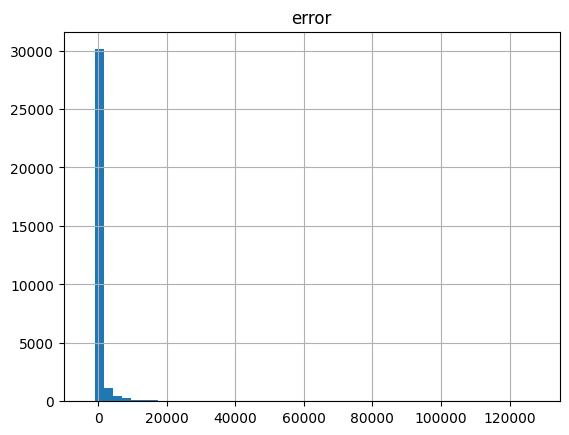

In [28]:
error_df.hist(column="error", bins=50);

Now zoom the histogram to the (-200, 5000) range. 

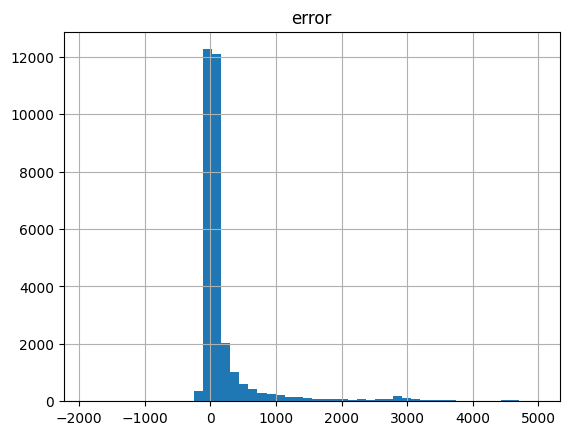

In [29]:
error_df[(error_df["error"] > -2000) & (error_df["error"] < 5000)].hist(column="error", bins=50);

In [30]:
error_df["error"].mean(), error_df["error"].std()

(737.2015192787788, 3649.793905115646)

In [31]:
error_df["error"].median()

50.19432569117498

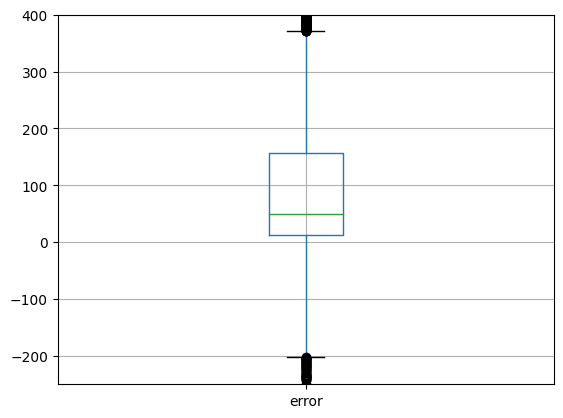

In [32]:
ax = error_df.boxplot(column="error")
ax.set_ylim(-250, 400);

Calculate the quartiles and the Tukey fences.

In [33]:
q25, q50, q75 = error_df["error"].quantile(0.25), \
                error_df["error"].quantile(0.5),  \
                error_df["error"].quantile(0.75)

In [34]:
iqr = q75 - q25
tukey_min, tukey_max = q25 - 1.5 * iqr, q75 + 1.5 * iqr

In [35]:
tukey_min, tukey_max

(-202.27711077660751, 371.7823667579378)

In [36]:
q25, q50, q75

(12.99519329884697, 50.19432569117498, 156.5100626824833)

In [37]:
error_df[(error_df["error"] >= tukey_min) & (error_df["error"] <= tukey_max)].shape[0]

27196

In [38]:
out_df = error_df[(error_df["error"] < tukey_min) | (error_df["error"] > tukey_max)]

In [39]:
out_df.shape

(5332, 2)

In [40]:
out_df.sort_values("error")

,traj_id,error
536,538,-3460.206503
2973,2980,-2332.673734
27991,28014,-1891.352110
2178,2184,-1622.975706
5817,5827,-1294.645764
...,...,...
10178,10190,100477.624287
8616,8626,100840.098546
16041,16058,105923.546166
30735,30759,109359.715704
